In [2]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import cerberus
import pyranges as pr
import upsetplot

p = os.path.dirname(os.getcwd())
sys.path.append(p)

from scripts.utils import *
from scripts.vcf_utils import *
from scripts.plotting import *

In [3]:
config = load_config()
od = '../'

def proc_cfg(entry, od):
    entry = entry.replace('../../', '')
    entry = od+entry
    return entry

In [4]:
sample = 'HG00621_1'
sample_1 = sample.split('_')[0]
assemblies = ['afr', 'hg38', 't2t']
meta = load_meta()
pop = meta.loc[meta['sample'] == sample_1, 'population'].values[0]
c_dict, _ = get_population_colors()
color = c_dict[pop]

## upset plot showing which reads mapped to where? Binary (min mapq >0)

In [20]:
thresh = 0

t2t_file = proc_cfg(expand(config['lr']['map']['bam_mapqs'],
                          sample=sample,
                          assembly='t2t')[0], od)
hg38_file = proc_cfg(expand(config['lr']['map']['bam_mapqs'],
                          sample=sample,
                          assembly='hg38')[0], od)
afr_file = proc_cfg(expand(config['lr']['map']['bam_mapqs'],
                          sample=sample,
                          assembly='afr')[0], od)

df = pd.read_csv(hg38_file, sep='\t')
df.rename({'mapq':'hg38'}, axis=1, inplace=True)
assert len(df.index) == len(df.read_id.unique())

df2 = pd.read_csv(t2t_file, sep='\t')
df2.rename({'mapq':'t2t'}, axis=1, inplace=True)
assert len(df2.index) == len(df2.read_id.unique())

df3 = pd.read_csv(afr_file, sep='\t')
df3.rename({'mapq':'afr'}, axis=1, inplace=True)
assert len(df3.index) == len(df3.read_id.unique())

df = df.merge(df2, how='outer', on='read_id')
df = df.merge(df3, how='outer', on='read_id')

# convert to binary
df.fillna(0, inplace=True)
df.set_index('read_id', inplace=True)
df = df>thresh

df.reset_index(inplace=True)
df.set_index(['hg38', 't2t', 'afr'], inplace=True)

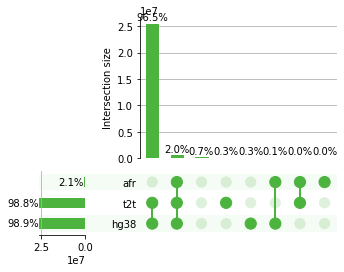

In [26]:
ax_dict = upsetplot.UpSet(df, subset_size='count',
                          facecolor=color,
                          sort_by='cardinality',
                          show_counts=False,
                          show_percentages=True).plot()

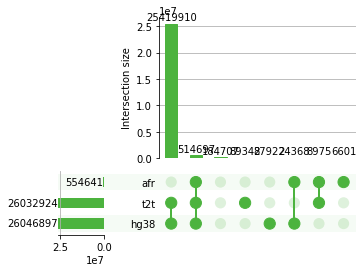

In [27]:
ax_dict = upsetplot.UpSet(df, subset_size='count',
                          facecolor=color,
                          sort_by='cardinality',
                          show_counts=True).plot()

## upset plot showing which reads mapped to where? Binary (min mapq >10)

In [32]:
thresh = 10

t2t_file = proc_cfg(expand(config['lr']['map']['bam_mapqs'],
                          sample=sample,
                          assembly='t2t')[0], od)
hg38_file = proc_cfg(expand(config['lr']['map']['bam_mapqs'],
                          sample=sample,
                          assembly='hg38')[0], od)
afr_file = proc_cfg(expand(config['lr']['map']['bam_mapqs'],
                          sample=sample,
                          assembly='afr')[0], od)

df = pd.read_csv(hg38_file, sep='\t')
df.rename({'mapq':'hg38'}, axis=1, inplace=True)
assert len(df.index) == len(df.read_id.unique())

df2 = pd.read_csv(t2t_file, sep='\t')
df2.rename({'mapq':'t2t'}, axis=1, inplace=True)
assert len(df2.index) == len(df2.read_id.unique())

df3 = pd.read_csv(afr_file, sep='\t')
df3.rename({'mapq':'afr'}, axis=1, inplace=True)
assert len(df3.index) == len(df3.read_id.unique())

df = df.merge(df2, how='outer', on='read_id')
df = df.merge(df3, how='outer', on='read_id')

# convert to binary
df.fillna(0, inplace=True)
df.set_index('read_id', inplace=True)
df = df>thresh

df.reset_index(inplace=True)
df.set_index(['hg38', 't2t', 'afr'], inplace=True)

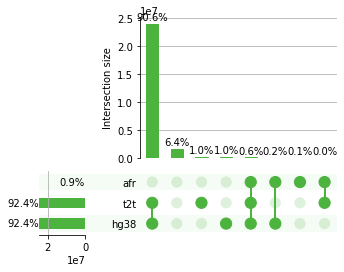

In [33]:
ax_dict = upsetplot.UpSet(df, subset_size='count',
                          facecolor=color,
                          sort_by='cardinality',
                          show_counts=False,
                          show_percentages=True).plot()
plt.suptitle(f'Reads w/ mapq>{thresh}')

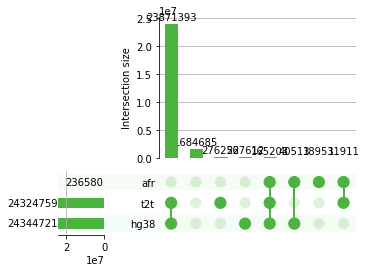

In [34]:
ax_dict = upsetplot.UpSet(df, subset_size='count',
                          facecolor=color,
                          sort_by='cardinality',
                          show_counts=True).plot()
plt.suptitle(f'Reads w/ mapq>{thresh}')

## bar plot showing which reads mapped best (mapq)

In [5]:
sample = 'HG00621_1'
sample_1 = sample.split('_')[0]
assemblies = ['afr', 'hg38', 't2t']
meta = load_meta()
pop = meta.loc[meta['sample'] == sample_1, 'population'].values[0]
c_dict, _ = get_population_colors()
color = c_dict[pop]

thresh = 0

In [6]:
files = expand(proc_cfg(config['lr']['map']['bam_mapqs'], od),
                          sample=sample,
                          assembly=assemblies)

In [9]:
i = 0
for f, a in zip(files, assemblies):
    temp = pd.read_csv(f, sep='\t')
    # temp.rename({'mapq':a}, axis=1, inplace=True)
    assert len(temp.index) == len(temp.read_id.unique())
    temp['assembly']=a

    
    if i == 0:
        df = temp.copy(deep=True)
    else:
        df = pd.concat([df, temp], axis=0)
    i += 1

In [11]:
df_back = df.copy(deep=True)

In [22]:
df = df_back.copy(deep=True)

In [23]:
df.head()

,read_id,mapq,assembly
0,f87d20ec-f864-44d5-9a24-a7366cd0f9ad:0,1,afr
1,5881373b-81a1-42a0-8555-9ac336dae87d:0,16,afr
2,6836a82f-88a6-42ba-b52f-f877d3e578da:0_1,1,afr
3,f540d9cd-e5cd-4183-bcee-4b78b8aa24ff:0,1,afr
4,2357c9be-1000-4835-9bdf-30b0389218e6:0,1,afr


In [24]:
# assert min mapq
df = df.loc[df.mapq>thresh]

# groupby read id and mapq to find reads that map equally as well
df = df.groupby(['read_id', 'mapq']).agg({
    'assembly': lambda x: ','.join(x)})

In [25]:
df.head()

assembly
read_id                                mapq          
00000071-0e5d-48b9-a083-c6ddcf2d7022:0 1          t2t
                                       22        hg38
00000281-2420-4d56-8131-d069fdfc747c:0 60    hg38,t2t
00000314-4ba4-4a61-b20f-214df69fd145:0 46         t2t
                                       60        hg38

In [26]:
# sort by mapq and dedupe by keeping max
df.reset_index(inplace=True)
df = df.sort_values(by='mapq', ascending=False)
df = df.drop_duplicates(subset=['read_id'], keep='first')

In [27]:
# process out using the upset plot stuff
df['assembly'] = df.assembly.str.split(',')

In [28]:
df = upsetplot.from_memberships(df.assembly)

Text(0.5, 0.98, 'best_mapq')

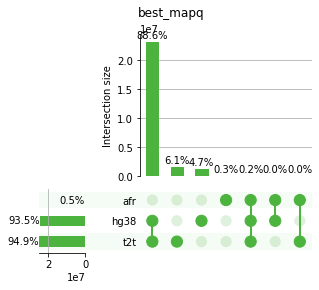

In [30]:
ax_dict = upsetplot.UpSet(df, subset_size='count',
                          facecolor=color,
                          sort_by='cardinality',
                          show_percentages=True).plot()
plt.suptitle('best_mapq') # TODO fix the title

In [31]:
df.head()

afr    hg38   t2t 
False  True   True    1
       False  True    1
       True   True    1
              True    1
              True    1
Name: ones, dtype: int64

## old

In [37]:
thresh = 10

t2t_file = proc_cfg(expand(config['lr']['map']['bam_mapqs'],
                          sample=sample,
                          assembly='t2t')[0], od)
hg38_file = proc_cfg(expand(config['lr']['map']['bam_mapqs'],
                          sample=sample,
                          assembly='hg38')[0], od)
afr_file = proc_cfg(expand(config['lr']['map']['bam_mapqs'],
                          sample=sample,
                          assembly='afr')[0], od)

df = pd.read_csv(hg38_file, sep='\t')
df['assembly']='hg38'
assert len(df.index) == len(df.read_id.unique())

df2 = pd.read_csv(t2t_file, sep='\t')
df2['assembly']='t2t'
assert len(df2.index) == len(df2.read_id.unique())

df3 = pd.read_csv(afr_file, sep='\t')
df3['assembly']='afr'
assert len(df3.index) == len(df3.read_id.unique())


In [38]:
# concat
df = pd.concat([df, df2, df3], axis=0)
df_back = df.copy(deep=True)


In [45]:
df = df_back.copy(deep=True)

In [46]:
# assert min mapq
df = df.loc[df.mapq>thresh]

# groupby read id and mapq to find reads that map equally as well
df = df.groupby(['read_id', 'mapq']).agg({
    'assembly': lambda x: ','.join(x)})

In [17]:
# sort by mapq and dedupe by keeping max
df.reset_index(inplace=True)
df = df.sort_values(by='mapq', ascending=False)
df = df.drop_duplicates(subset=['read_id'], keep='first')

In [18]:
# process out using the upset plot stuff
df['assembly'] = df.assembly.str.split(',')

In [19]:
df = upsetplot.from_memberships(df.assembly)

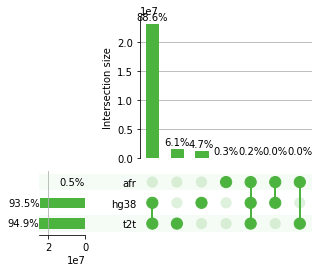

In [20]:
ax_dict = upsetplot.UpSet(df, subset_size='count',
                          facecolor=color,
                          sort_by='cardinality',
                          show_percentages=True).plot()
# TODO good title

In [21]:
df.head()

afr    hg38   t2t 
False  True   True    1
       False  True    1
       True   True    1
              True    1
              True    1
Name: ones, dtype: int64

Text(0.5, 0.98, 'best_mapq')

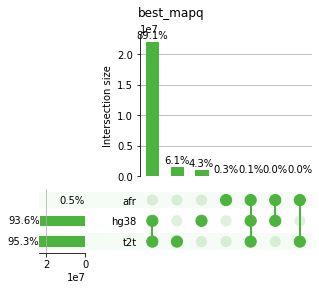

In [56]:
ax_dict = upsetplot.UpSet(df, subset_size='count',
                          facecolor=color,
                          sort_by='cardinality',
                          show_percentages=True).plot()
plt.suptitle('best_mapq')

## upset plot showing which reads mapped to where? Binary (min qcov>90)

In [63]:
thresh = 0.9

t2t_file = proc_cfg(expand(config['lr']['map']['bam_query_covs'],
                          sample=sample,
                          assembly='t2t')[0], od)
hg38_file = proc_cfg(expand(config['lr']['map']['bam_query_covs'],
                          sample=sample,
                          assembly='hg38')[0], od)
afr_file = proc_cfg(expand(config['lr']['map']['bam_query_covs'],
                          sample=sample,
                          assembly='afr')[0], od)

df = pd.read_csv(hg38_file, sep='\t')
df.drop(['read_len', 'chr'], axis=1, inplace=True)
df.rename({'query_cov':'hg38'}, axis=1, inplace=True)
assert len(df.index) == len(df.read_id.unique())

df2 = pd.read_csv(t2t_file, sep='\t')
df2.drop(['read_len', 'chr'], axis=1, inplace=True)
df2.rename({'query_cov':'t2t'}, axis=1, inplace=True)
assert len(df2.index) == len(df2.read_id.unique())

df3 = pd.read_csv(afr_file, sep='\t')
df3.drop(['read_len', 'chr'], axis=1, inplace=True)
df3.rename({'query_cov':'afr'}, axis=1, inplace=True)
assert len(df3.index) == len(df3.read_id.unique())

df = df.merge(df2, how='outer', on='read_id')
df = df.merge(df3, how='outer', on='read_id')

# convert to binary
df.fillna(0, inplace=True)
df.set_index('read_id', inplace=True)
df = df>thresh

df.reset_index(inplace=True)
df.set_index(['hg38', 't2t', 'afr'], inplace=True)

Text(0.5, 0.98, 'Reads w/ qcov>0.9')

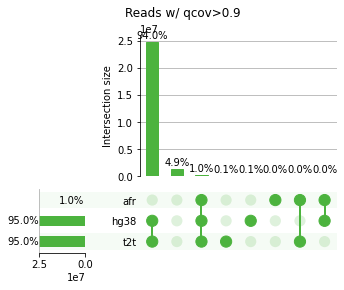

In [64]:
ax_dict = upsetplot.UpSet(df, subset_size='count',
                          facecolor=color,
                          sort_by='cardinality',
                          show_counts=False,
                          show_percentages=True).plot()
plt.suptitle(f'Reads w/ qcov>{thresh}')

Text(0.5, 0.98, 'Reads w/ qcov>0.9')

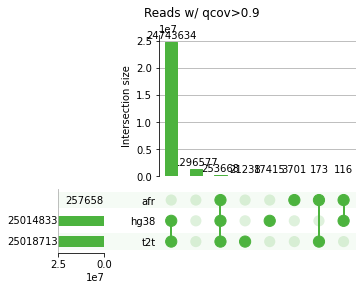

In [65]:
ax_dict = upsetplot.UpSet(df, subset_size='count',
                          facecolor=color,
                          sort_by='cardinality',
                          show_counts=True).plot()
plt.suptitle(f'Reads w/ qcov>{thresh}')

## bar plot showing which reads mapped best (qcov)